# Prosup  Classifier

In [111]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Nikhil/day_05_13_21/computed_bulb.csv'}>

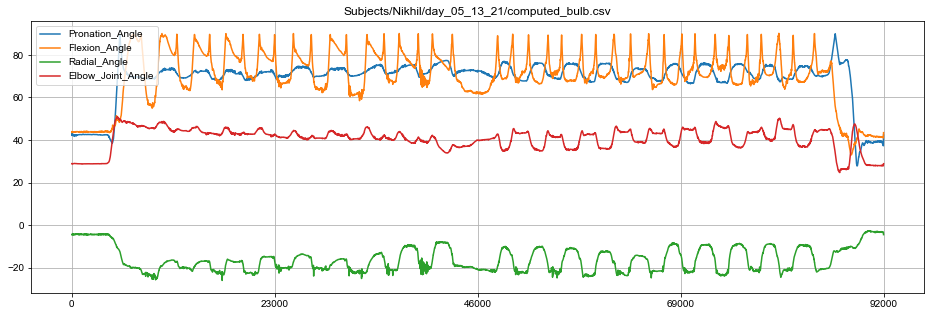

In [143]:
file = 'Subjects/Nikhil/day_05_13_21/computed_bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

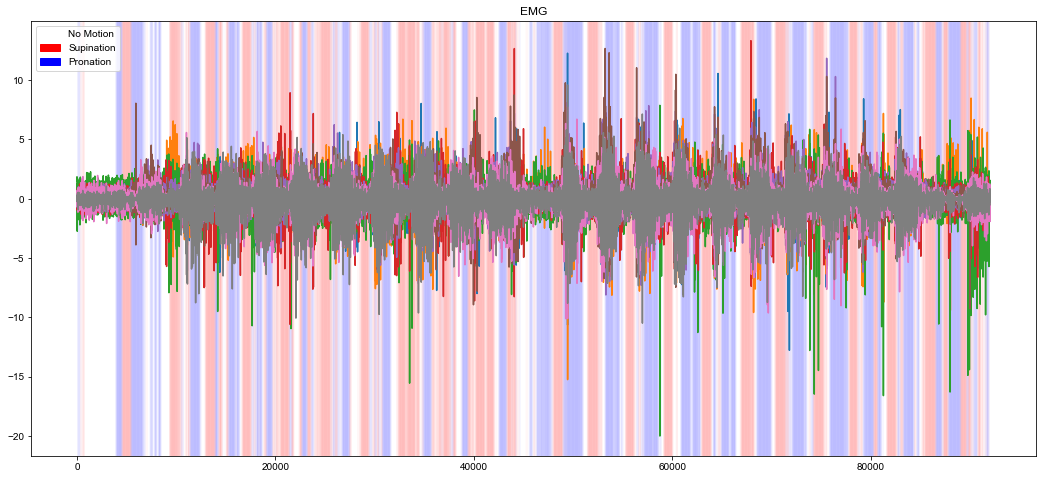

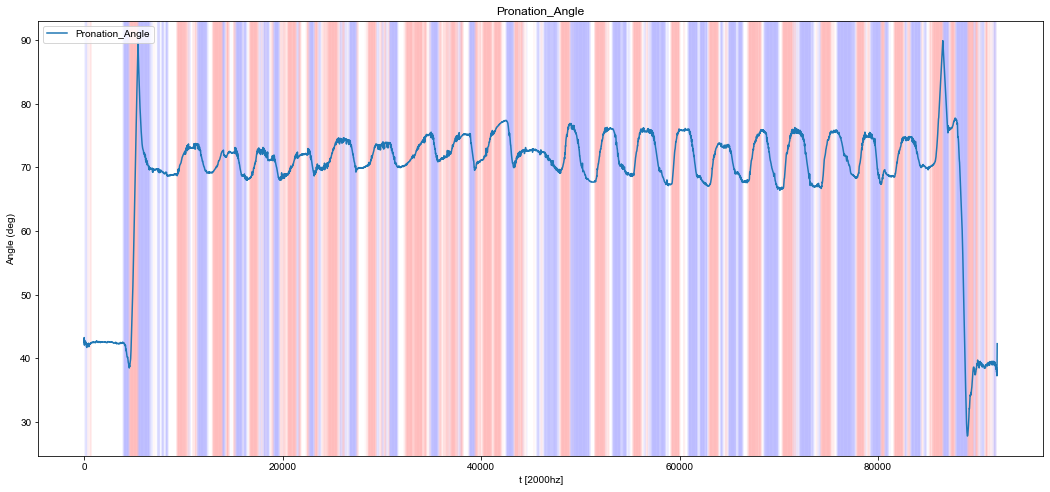

0 -> 31.469674677129312 %
1 -> 34.05264018309629 %
2 -> 34.4776851397744 %


(6117, 250, 8)

In [144]:
X, y = prep_data_prosup(df,250,interval=15,Normalize=False,plot=True,angle_thresh=0.001,rms=False)
X.shape

## File Name Generation

In [117]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'

In [118]:
for subj in subjects:
    path = 'Subjects/'+subj
#     trial_names = ['Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw']
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [119]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [120]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    b,a = signal.butter(1, 50,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
    return files_df

In [121]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [122]:
files_df = filter_df(files_df)

## Data Augumentation

### Gausian Noise

In [11]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

44

### Rearrange 

In [123]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [124]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

72

## Data Prep Pipeline

### Parameters

In [125]:
window = 250
interval = 30
Normalize = False
rms = False
angle_thresh_DTM = 0.001

In [126]:
X_prosup, y_prosup = multiple_prep_data_prosup(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)
print(X_prosup.shape,y_prosup.shape)


(151830, 250, 8) (151830, 3)


In [ ]:
np.save('X_test_raw',X_dtm)
np.save('y_test_raw',y_dtm)

## Whole Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [10]:
# X = X_dtm.reshape((X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2]))
# old_range = [X.min(),X.max()]
# new_range = [-1,1]
# scale_param = np.array([old_range,new_range])
# X = map_it(X,old_range,new_range)
# np.save('scale_param',scale_param)
# X = min_max(X)
# X = norm(X)
# X_dtm = X.reshape(X_dtm.shape)

# X = []
# for x in tqdm(X_dtm):
#     X.append(map_it(x,
#                     (x.min(),x.max()),
#                     (-1,1)))
# X_dtm = np.array(X)

In [127]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [128]:
X_mean = np.zeros(X_prosup[0].shape)
for x in X_prosup:
    X_mean = X_mean + x
X_mean = X_mean/X_prosup.shape[0]
X_std = np.sqrt(variance(X_prosup))
np.save('mean_std',np.array([X_mean,X_std]))

In [129]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

In [68]:
X = []
for x in tqdm(X_dtm):
    arr = x.copy()
    arr = (arr - arr.mean())/np.sqrt(variance(arr))
    X.append(arr)
X_dtm = np.array(X) 

NameError: name 'X_dtm' is not defined

In [130]:
np.save('prepared_data/X_prosup_rearr_tw',X_prosup)
np.save('prepared_data/y_prosup_rearr_tw',y_prosup)

In [2]:
X_prosup = np.load('prepared_data/X_prosup_rearr_tw.npy')
y_prosup = np.load('prepared_data/y_prosup_rearr_tw.npy')

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_prosup, y_prosup,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(121464, 250, 8)
(30366, 250, 8)
(121464, 3)
(30366, 3)


In [132]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [133]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [134]:
print(count(y_train))
print(count(y_test))

0 - 45500 [ 37.45965882895344 %]
1 - 37621 [ 30.97296318250675 %]
2 - 38343 [ 31.567377988539814 %]
None
0 - 11281 [ 37.15010208786143 %]
1 - 9254 [ 30.474873213462423 %]
2 - 9831 [ 32.37502469867615 %]
None


# InceptionTime Trainer

In [135]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [136]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=256,nb_epochs=40,nb_filters=32,
                            depth=10, kernel_size=11)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 32)      256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 250, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 32)      10240       conv1d[0][0]                     
______________________________________________________________________________________________

In [137]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/40
475/475 [==============================] - 101s 195ms/step - loss: 0.9510 - accuracy: 0.5389 - val_loss: 0.9178 - val_accuracy: 0.5592


C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
475/475 [==============================] - 112s 235ms/step - loss: 0.7191 - accuracy: 0.6837 - val_loss: 0.6718 - val_accuracy: 0.7122
Epoch 3/40
475/475 [==============================] - 110s 231ms/step - loss: 0.5194 - accuracy: 0.7871 - val_loss: 1.0388 - val_accuracy: 0.6214
Epoch 4/40
475/475 [==============================] - 109s 230ms/step - loss: 0.4086 - accuracy: 0.8396 - val_loss: 0.5891 - val_accuracy: 0.7723
Epoch 5/40
475/475 [==============================] - 110s 231ms/step - loss: 0.3460 - accuracy: 0.8657 - val_loss: 0.4295 - val_accuracy: 0.8364
Epoch 6/40
475/475 [==============================] - 110s 231ms/step - loss: 0.3058 - accuracy: 0.8836 - val_loss: 0.3667 - val_accuracy: 0.8591
Epoch 7/40
475/475 [==============================] - 109s 229ms/step - loss: 0.2768 - accuracy: 0.8955 - val_loss: 0.6000 - val_accuracy: 0.7786
Epoch 8/40
475/475 [==============================] - 109s 230ms/step - loss: 0.2560 - accuracy: 0.9031 - val_loss: 0.3442 -

In [ ]:
clf.model = load_model('models/prosup_250_tw_rearr.hdf5')

In [138]:
best_model = load_model('best_model.hdf5')
best_model.save('models/prosup_{}_tw_rearr.hdf5'.format(window))

C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [139]:
system_sleep()

## Testing

In [25]:
model = load_model('best_model.hdf5')

In [33]:
# mx_scaler = load(open('min_max.pkl', 'rb'))
# std_scaler = load(open('standard_scaler.pkl', 'rb'))

# X = mx_scaler.transform(X)
# X = std_scaler.transform(X)
X = X_dtm.reshape(X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2])
scale_param = np.load('scale_param.npy')
print(scale_param)
X = map_it(X,scale_param[0],scale_param[1])
X_dtm = X.reshape(X_dtm.shape)

[[-2.50412559  1.50388032]
 [-1.          1.        ]]


In [34]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]

In [35]:
X = []
for x in tqdm(X_dtm):
    X.append((x-X_mean)/X_std)
X_dtm = np.array(X)

In [36]:
model.evaluate(X_dtm,y_dtm)

4745/4745 [==============================] - 51s 11ms/step - loss: 35298.5703 - accuracy: 0.3006


[35298.5703125, 0.3005908131599426]

## Plot Results

In [140]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [141]:
metrics_df

,precision,accuracy,recall,duration
0,0.946481,0.944675,0.945249,5498.593899


<AxesSubplot:title={'center':'Loss'}>

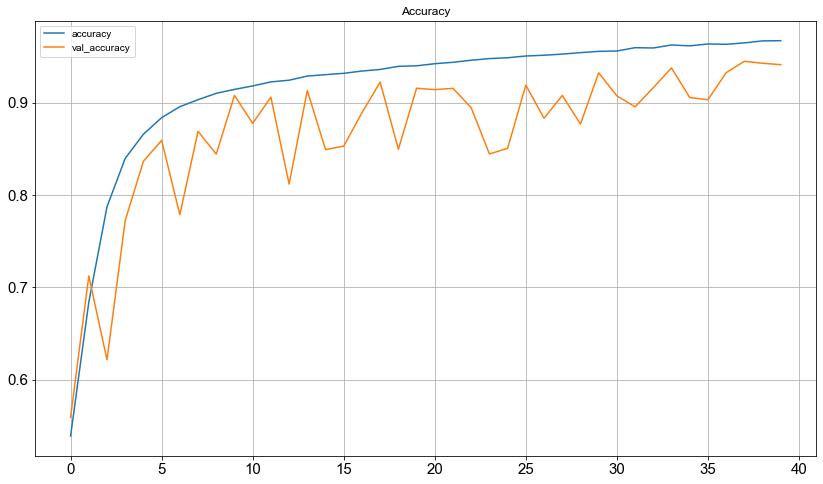

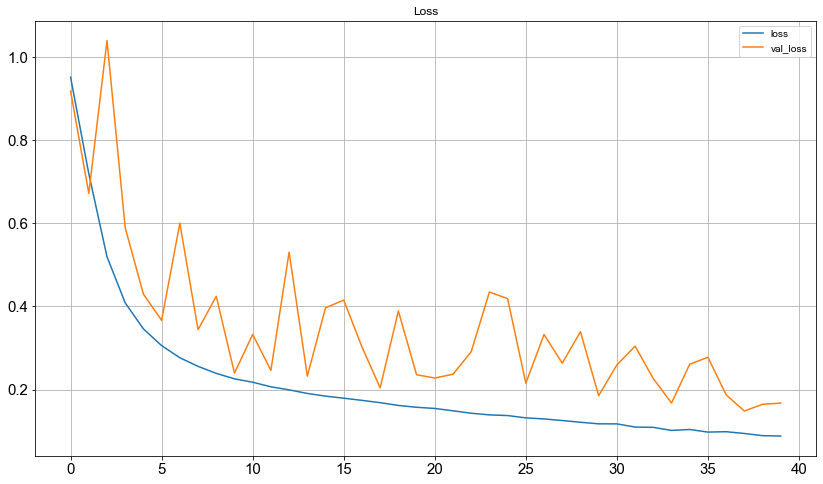

In [142]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
system_sleep()